In [1]:
import os
import logging
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# logging.basicConfig(level=logging.ERROR)
logging.disable(logging.WARNING)

In [2]:
%matplotlib inline
import mindspore as m

m.set_context(mode=m.GRAPH_MODE, device_target="GPU") # 训练时使用静态图
# m.set_context(mode=m.PYNATIVE_MODE, device_target="GPU") # 设置为动态图方便debug

将MindSpore设置为图执行模式，并设置为使用GPU进行训练。

In [3]:
train_data_path = r"data/MPI-Sintel-complete/training"
val_data_path = r"data/MPI-Sintel-complete/training"

pretrained_path = r"pretrained_model/pwcnet-mindspore.ckpt"

batch_size = 4
lr = 0.0001
num_parallel_workers = 4
lr_milestones = '6,10,12,16'
lr_gamma = 0.5
max_epoch = 20
loss_scale = 1024
warmup_epochs = 1

设置数据集路径，设置训练参数，包括batch_size、epoch_size、learning_rate等。

In [4]:
import mindspore.dataset.vision as V

from src.dataset_utils import RandomGamma

augmentation_list = [
    V.ToPIL(),
    V.RandomColorAdjust(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    V.ToTensor(),
    RandomGamma(min_gamma=0.7, max_gamma=1.5, clip_image=True),
]


设置数据增强方法，包括使用随机颜色变换和随机Gamma变换。

In [5]:
from black import out
from src.dataset import getFlyingChairsTrainData, getSintelValData

dl_train, len_dl_train, dataset = getSintelValData(
    root=train_data_path,
    split="train",
    augmentations=augmentation_list,
    batch_size=batch_size,
    num_parallel_workers=num_parallel_workers,
)
dl_val, len_dl_val, val_dataset = getSintelValData(
    root=val_data_path,
    split="train",
    augmentations=augmentation_list,
    batch_size=batch_size,
    num_parallel_workers=num_parallel_workers,
)
train_len = dl_train.get_dataset_size()
dl_train = dl_train.repeat(max_epoch)
print(f"The dataset size of dl_train: {dl_train.get_dataset_size()}")
print(f"The dataset size of dl_val: {dl_val.get_dataset_size()}")

dict_datasets = next(dl_train.create_dict_iterator())
print(dict_datasets.keys())
print(dict_datasets["im1"].shape)
print(dict_datasets["im2"].shape)
print(dict_datasets["flo"].shape)
print(type(dict_datasets["flo"]))
print(dict_datasets["flo"].max(), dict_datasets["flo"].min())
print(dict_datasets["flo"].max() * 0.05, dict_datasets["flo"].min() * 0.05)
dl_train = dl_train.create_tuple_iterator(output_numpy=False, do_copy=False)
dl_val = dl_val.create_tuple_iterator(output_numpy=False, do_copy=False)

SintelDataset: 133 val flows, 908 train flows
SintelDataset: 133 val flows, 908 train flows
The dataset size of dl_train: 4540
The dataset size of dl_val: 227
dict_keys(['im1', 'im2', 'flo'])
(4, 3, 384, 512)
(4, 3, 384, 512)
(4, 2, 384, 512)
<class 'mindspore.common.tensor.Tensor'>
10.763061 -13.777097
0.53815305 -0.6888549


查看数据集的训练集和测试集的数量。同时查看数据集中RGB图片和光流图片的分辨率大小。

Text(0.5, 1.0, 'Optical Flow')

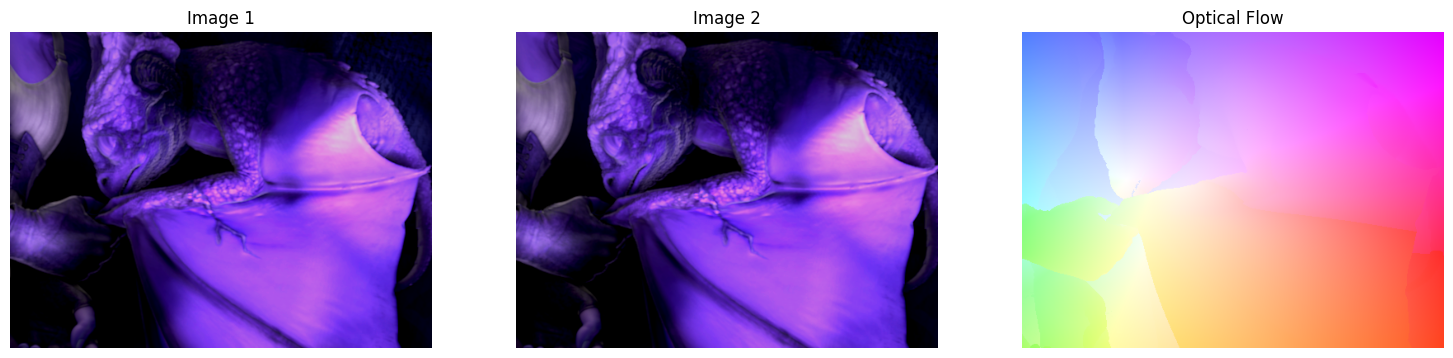

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import flow_vis

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.subplot(131)
ax.imshow(np.transpose(dict_datasets["im1"][0].asnumpy(), (1, 2, 0)))
ax.set_title("Image 1")
ax.set_axis_off()
ax = plt.subplot(132)
ax.imshow(np.transpose(dict_datasets["im2"][0].asnumpy(), (1, 2, 0)))
ax.set_title("Image 2")
ax.set_axis_off()
ax = plt.subplot(133)
ax.imshow(
    flow_vis.flow_to_color(np.transpose(dict_datasets["flo"][0].asnumpy(), (1, 2, 0)))
)
ax.set_axis_off()
ax.set_title("Optical Flow")


使用`flow_vis`和`matplotlib`库分别将光流图片与RGB图片可视化。

In [7]:
# from src.pwc_net import PWCNet
# from src.loss import PyramidEPE, MultiStepLR

# from mindspore.nn import Adam

# network = PWCNet()
# criterion = PyramidEPE()

# optimizer = Adam(params=net.trainable_params(), learning_rate=lr, loss_scale=loss_scale)


In [8]:
from collections import Counter
import numpy as np

class _WarmUp():
    """
    Basic class for warm up
    """
    def __init__(self, warmup_init_lr):
        self.warmup_init_lr = warmup_init_lr

    def get_lr(self):
        # Get learning rate during warmup
        raise NotImplementedError

class _LRScheduler():
    """
    Basic class for learning rate scheduler
    """
    def __init__(self, lr, max_epoch, steps_per_epoch):
        self.base_lr = lr
        self.steps_per_epoch = steps_per_epoch
        self.total_steps = int(max_epoch * steps_per_epoch)

    def get_lr(self):
        # Compute learning rate using chainable form of the scheduler
        raise NotImplementedError

class _LinearWarmUp(_WarmUp):
    """
    Class for linear warm up
    """
    def __init__(self, lr, warmup_epochs, steps_per_epoch, warmup_init_lr=0):
        self.base_lr = lr
        self.warmup_init_lr = warmup_init_lr
        self.warmup_steps = int(warmup_epochs * steps_per_epoch)

        super(_LinearWarmUp, self).__init__(warmup_init_lr)

    def get_warmup_steps(self):
        return self.warmup_steps

    def get_lr(self, current_step):
        lr_inc = (float(self.base_lr) - float(self.warmup_init_lr)) / float(self.warmup_steps)
        lr = float(self.warmup_init_lr) + lr_inc * current_step
        return lr

class MultiStepLR(_LRScheduler):
    """
    Multi-step learning rate scheduler

    Decays the learning rate by gamma once the number of epoch reaches one of the milestones.

    Args:
        lr (float): Initial learning rate which is the lower boundary in the cycle.
        milestones (list): List of epoch indices. Must be increasing.
        gamma (float): Multiplicative factor of learning rate decay.
        steps_per_epoch (int): The number of steps per epoch to train for.
        max_epoch (int): The number of epochs to train for.
        warmup_epochs (int, optional): The number of epochs to Warmup. Default: 0

    Outputs:
        numpy.ndarray, shape=(1, steps_per_epoch*max_epoch)

    Example:
        >>> # Assuming optimizer uses lr = 0.05 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 80
        >>> # lr = 0.0005   if epoch >= 80
        >>> scheduler = MultiStepLR(lr=0.1, milestones=[30,80], gamma=0.1, steps_per_epoch=5000, max_epoch=90)
        >>> lr = scheduler.get_lr()
    """

    def __init__(self, lr, milestones, gamma, steps_per_epoch, max_epoch, warmup_epochs=0):
        self.milestones = Counter(milestones)
        self.gamma = gamma
        self.warmup = _LinearWarmUp(lr, warmup_epochs, steps_per_epoch)
        super(MultiStepLR, self).__init__(lr, max_epoch, steps_per_epoch)

    def get_lr(self):
        warmup_steps = self.warmup.get_warmup_steps()

        lr_each_step = []
        current_lr = self.base_lr
        for i in range(self.total_steps):
            if i < warmup_steps:
                lr = self.warmup.get_lr(i+1)
            else:
                cur_ep = i // self.steps_per_epoch
                if i % self.steps_per_epoch == 0 and cur_ep in self.milestones:
                    current_lr = current_lr * self.gamma
                lr = current_lr

            lr_each_step.append(lr)

        return np.array(lr_each_step).astype(np.float32)

初始化神经网络、损失函数、优化器、模型和回调函数。

In [9]:
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.train.callback import LossMonitor, TimeMonitor
from mindspore import Model, load_checkpoint, load_param_into_net

from src.pwc_net import BuildTrainNetwork, PWCNet
from src.loss import PyramidEPE


class CustomWithLossCell(nn.Cell):

    def __init__(self, network, criterion):
        super(CustomWithLossCell, self).__init__(auto_prefix=False)
        self.network = network
        self.criterion = criterion

    def construct(self, im1, im2, flow):
        out = self.network(im1, im2)
        loss = self.criterion(out, flow)
        return loss

network = PWCNet()
criterion = PyramidEPE()

param_dict = load_checkpoint(pretrained_path)
param_dict_new = {}
for key, values in param_dict.items():
    if key.startswith('moment1.' or 'moment2' or 'global_step' or 'beta1_power' or 'beta2_power' or
                        'learning_rate'):
        continue
    elif key.startswith('network.'):
        param_dict_new[key[8:]] = values
    else:
        param_dict_new[key] = values
load_param_into_net(network, param_dict_new)

train_net = BuildTrainNetwork(network, criterion)

# model = Model(
#     network=net_with_loss,
#     # loss_fn=criterion,
#     optimizer=optimizer,
#     eval_network=net_with_loss,
#     metrics={"loss"},
#     amp_level="O0",
# )

In [10]:
from mindspore import Tensor
from mindspore.nn import Adam, TrainOneStepCell
lr_scheduler = MultiStepLR(lr, lr_milestones, lr_gamma, train_len, max_epoch, warmup_epochs)
lr_schedule = lr_scheduler.get_lr()
opt = Adam(params=network.trainable_params(), learning_rate=Tensor(lr_schedule), loss_scale=loss_scale)
train_net_step = TrainOneStepCell(train_net, opt)

In [11]:
import time

class AverageMeter():
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f', tb_writer=None):
        self.name = name
        self.fmt = fmt
        self.reset()
        self.tb_writer = tb_writer
        self.cur_step = 1

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        if self.tb_writer is not None:
            self.tb_writer.add_scalar(self.name, self.val, self.cur_step)
        self.cur_step += 1

    def __str__(self):
        fmtstr = '{name}:{avg' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)

train_net_step = train_net_step.set_train()
t_end = time.time()
t_epoch = time.time()
create_network_start = time.time()
old_progress = -1
loss_meter = AverageMeter('loss')
best_val_loss = 1e10

In [12]:
print('Start training...')
for i, data in enumerate(dl_train):
    # clean grad + adjust lr + put data into device + forward + backward + optimizer, return loss
    # print(data[0].shape, data[1].shape, data[2].shape)
    # print(data[0].max(), data[0].min(), data[1].max(), data[1].min(), data[2].max(), data[2].min())
    loss = train_net_step(data[0], data[1], data[2])
    # print(loss)
    loss_meter.update(loss.asnumpy())
    
    if i == 0:
        time_for_graph_compile = time.time() - create_network_start
        print('graph compile time={:.2f}s'.format(time_for_graph_compile))
        
    if i % 10 == 0 and i > 0:
        t_now = time.time()
        epoch = int(i / train_len)
        print('epoch: [{}], iter: [{}], loss: [{:.4f}], time: [{:.2f}]s'.format(epoch, i, loss_meter.avg, t_now - t_end))
        t_end = t_now
        loss_meter.reset()
    
    if i % train_len == 0  and i > 0:
        epoch_time_used = time.time() - t_epoch
        epoch = int(i / train_len)
        fps = batch_size * train_len / epoch_time_used
        print('=================================================')
        print('epoch[{}], iter[{}], [{:.2f}] imgs/sec'.format(epoch, i, fps))
        t_epoch = time.time()
        validation_loss = 0
        sum_num = 0
        for _, val_data in enumerate(dl_val):
            network.set_train(False)
            val_output = network(val_data[0], val_data[1], training=False)
            val_loss = criterion(val_output, val_data[2], training=False)
            validation_loss += val_loss
            sum_num += 1
        if (validation_loss / sum_num) < best_val_loss:
            best_val_loss = validation_loss / sum_num
        print('validation EPE: {}, best validation EPE: {}'.format(validation_loss / sum_num, best_val_loss))

Start training...
graph compile time=94.62s
epoch: [0], iter: [10], loss: [377.8884], time: [98.15]s
epoch: [0], iter: [20], loss: [231.8749], time: [3.41]s
epoch: [0], iter: [30], loss: [299.8118], time: [3.40]s
epoch: [0], iter: [40], loss: [362.5068], time: [3.41]s
epoch: [0], iter: [50], loss: [361.0948], time: [3.42]s
epoch: [0], iter: [60], loss: [192.4937], time: [3.41]s
epoch: [0], iter: [70], loss: [221.3818], time: [3.40]s
epoch: [0], iter: [80], loss: [84.0534], time: [3.40]s
epoch: [0], iter: [90], loss: [54.7355], time: [3.39]s
epoch: [0], iter: [100], loss: [73.9671], time: [3.39]s
epoch: [0], iter: [110], loss: [50.5655], time: [3.40]s
epoch: [0], iter: [120], loss: [58.4436], time: [3.39]s
epoch: [0], iter: [130], loss: [44.2014], time: [3.39]s
epoch: [0], iter: [140], loss: [35.0445], time: [3.39]s
epoch: [0], iter: [150], loss: [44.1013], time: [3.40]s
epoch: [0], iter: [160], loss: [50.6311], time: [3.42]s
epoch: [0], iter: [170], loss: [27.2759], time: [3.40]s
epoch

Text(0.5, 1.0, 'Predicted Optical Flow')

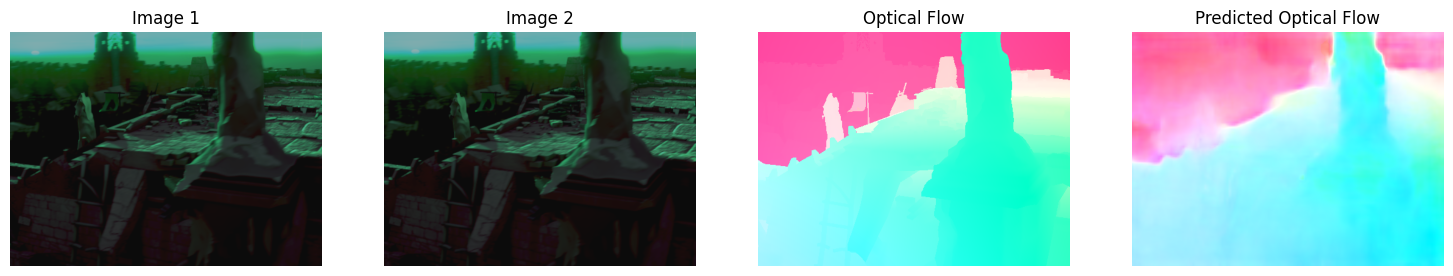

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import flow_vis

out_flow = network(dict_datasets['im1'][3][None, ...], dict_datasets['im2'][3][None, ...], training=False)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.subplot(141)
ax.imshow(np.transpose(dict_datasets["im1"][3].asnumpy(), (1, 2, 0)))
ax.set_title("Image 1")
ax.set_axis_off()
ax = plt.subplot(142)
ax.imshow(np.transpose(dict_datasets["im2"][3].asnumpy(), (1, 2, 0)))
ax.set_title("Image 2")
ax.set_axis_off()
ax = plt.subplot(143)
ax.imshow(
    flow_vis.flow_to_color(np.transpose(dict_datasets["flo"][3].asnumpy(), (1, 2, 0)))
)
ax.set_axis_off()
ax.set_title("Optical Flow")
ax = plt.subplot(144)
ax.imshow(
    flow_vis.flow_to_color(np.transpose(out_flow[0].asnumpy(), (1, 2, 0)))
)
ax.set_axis_off()
ax.set_title("Predicted Optical Flow")
# plt.show()
